In [44]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

In [2]:
store = pd.HDFStore('data.h5')
targ = store['targ']
parammat = store['parammat']

In [3]:
store.close()

In [4]:
from sklearn.model_selection import train_test_split
XTraining, XValidation, YTraining, YValidation = train_test_split(parammat,targ,test_size=0.1, shuffle=False) # before model building


In [5]:
import tensorflow as tf

from tensorflow import keras
from tensorflow.keras import layers

print(tf.__version__)
print(tf.config.list_physical_devices())

2024-05-12 17:35:07.804363: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2024-05-12 17:35:09.233463: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2024-05-12 17:35:09.237974: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-05-12 17:35:12.829782: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


2.13.1
[PhysicalDevice(name='/physical_device:CPU:0', device_type='CPU')]


In [29]:
def build_and_compile_model(norm):
  model = keras.Sequential([
      norm,
      layers.Dense(512, activation='relu'),
      layers.Dense(32, activation='relu'),

      layers.Dense(nflds)
  ])

  model.compile(loss='mae',
                optimizer=tf.keras.optimizers.AdamW(0.001))
  return model

In [30]:
fflds=targ.columns.get_level_values(0)
fdates=targ.columns.get_level_values(1)
flds=targ.columns.get_level_values(0).unique()
dates=targ.columns.get_level_values(1).unique()
nflds=targ.shape[1]
nflds

20

In [31]:
normalizer = tf.keras.layers.Normalization(input_shape=[parammat.shape[1],], axis=-1)
normalizer.adapt(parammat)
dnn_model = build_and_compile_model(normalizer)


In [32]:
X_train = tf.convert_to_tensor(XTraining, dtype=tf.float32)
Y_train = tf.convert_to_tensor(YTraining, dtype=tf.float32)
X_dev = tf.convert_to_tensor(XValidation, dtype=tf.float32)
Y_dev = tf.convert_to_tensor(YValidation, dtype=tf.float32)

In [33]:
from tqdm.keras import TqdmCallback

In [34]:
strategy = tf.distribute.MirroredStrategy()
print('Number of devices: {}'.format(strategy.num_replicas_in_sync))

INFO:tensorflow:Using MirroredStrategy with devices ('/job:localhost/replica:0/task:0/device:CPU:0',)
Number of devices: 1


In [39]:
if 0:
    history=dnn_model.fit(X_train, Y_train, epochs=30000, batch_size=256, validation_data=(X_dev, Y_dev),verbose=0,callbacks=[TqdmCallback(verbose=0)])
    dnn_model.save_weights('data/cicero_weights.h5')
else:
  dnn_model.load_weights('data/cicero_weights.h5')

In [46]:
dnn_model.save('data/dnn_cicero.keras')


In [40]:
pred = dnn_model.predict(X_dev)
pred_t = dnn_model.predict(X_train)

1407/1407 [==============================] - 1s 711us/step


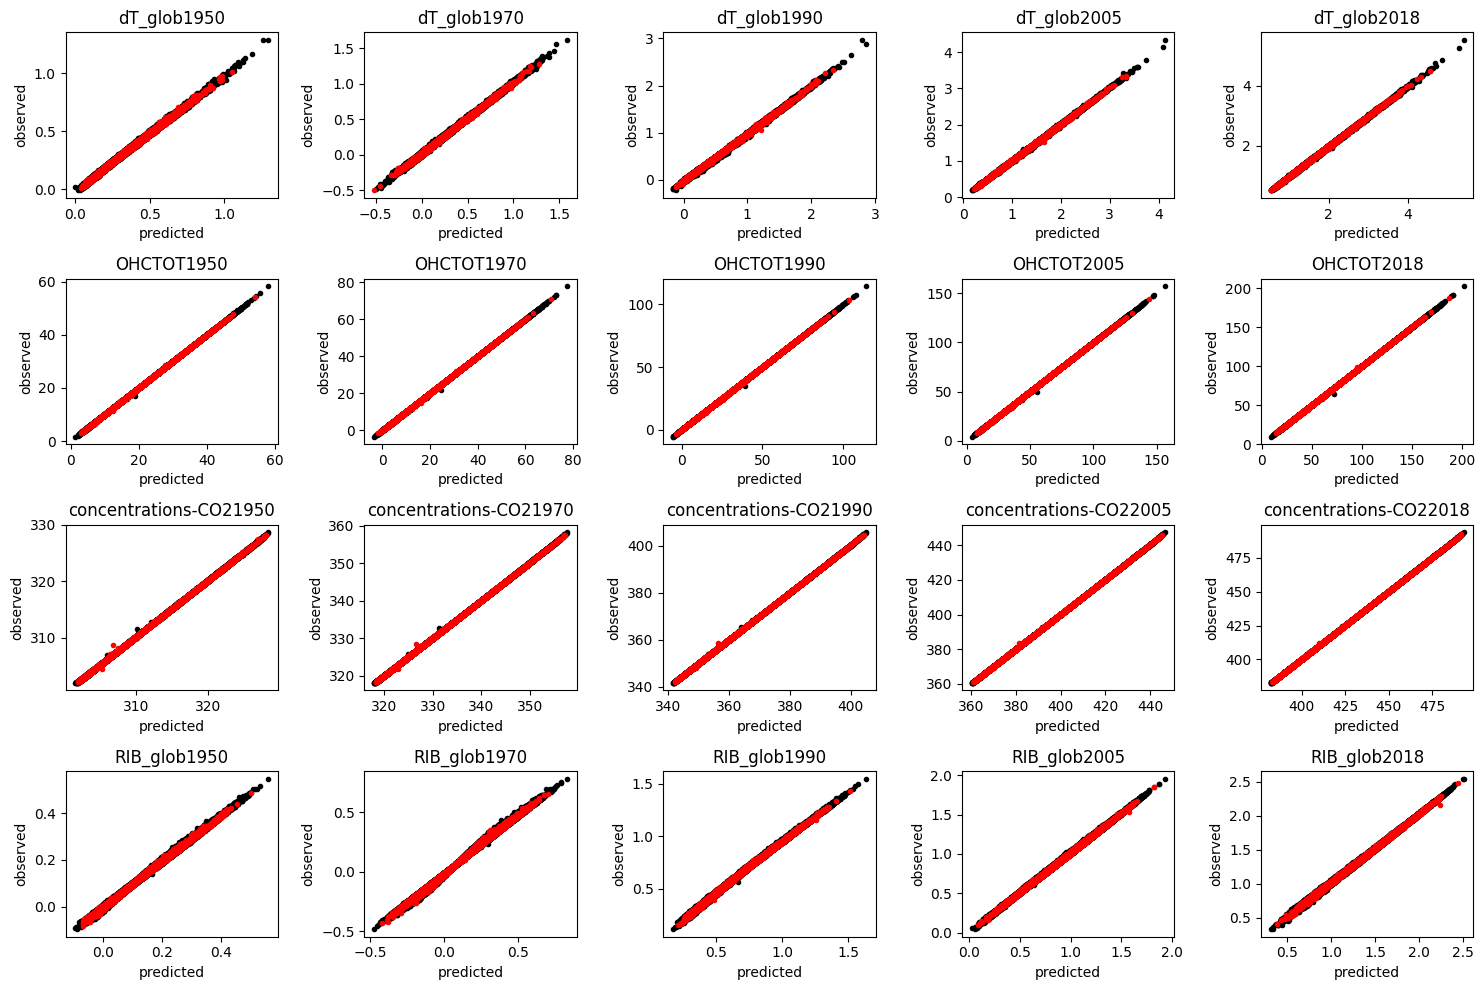

In [47]:
fig, ax = plt.subplots( len(flds), len(dates),figsize=(15, 10))

ax=ax.flatten()
for i in np.arange(nflds):
  ax[i].plot(pred_t[:,i],Y_train[:,i],'k.')
  ax[i].plot(pred[:,i],Y_dev[:,i],'r.')
  ax[i].set_title(fflds[i]+str(fdates[i]))
  ax[i].set_xlabel('predicted')
  ax[i].set_ylabel('observed')
plt.tight_layout()